In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import tensorflow as tf
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from difflib import SequenceMatcher
from math import sqrt, ceil

In [2]:
weather = pd.read_csv('weather_features.csv')
energy = pd.read_csv('energy_dataset.csv')

In [3]:
weather.shape

(178396, 17)

In [3]:
weather.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

In [4]:
print(weather.columns.values)

['dt_iso' 'city_name' 'temp' 'temp_min' 'temp_max' 'pressure' 'humidity'
 'wind_speed' 'wind_deg' 'rain_1h' 'rain_3h' 'snow_3h' 'clouds_all'
 'weather_id' 'weather_main' 'weather_description' 'weather_icon']


In [5]:
weather.city_name.value_counts()

Madrid        36267
Bilbao        35951
Seville       35557
 Barcelona    35476
Valencia      35145
Name: city_name, dtype: int64

In [6]:
weather.weather_description.value_counts()

sky is clear                    82685
few clouds                      32101
broken clouds                   17448
scattered clouds                15945
light rain                      10905
mist                             3908
moderate rain                    3621
overcast clouds                  2561
fog                              2506
light intensity drizzle          1241
heavy intensity rain             1142
light intensity shower rain       657
proximity thunderstorm            480
proximity shower rain             476
haze                              435
shower rain                       426
drizzle                           369
dust                              345
thunderstorm                      309
light snow                        140
thunderstorm with rain            127
thunderstorm with light rain       92
heavy intensity shower rain        81
light intensity drizzle rain       79
very heavy rain                    78
snow                               74
smoke       

In [7]:
weather.weather_main.value_counts()

clear           82685
clouds          68055
rain            17391
mist             3908
fog              2506
drizzle          1724
thunderstorm     1041
haze              435
dust              347
snow              270
smoke              33
squall              1
Name: weather_main, dtype: int64

In [8]:
weather.weather_id.value_counts()

800    82685
801    32101
803    17448
802    15945
500    10905
701     3908
501     3625
804     2561
741     2506
300     1241
502     1142
521      902
211      789
520      657
721      435
301      371
761      345
600      140
201      127
200       92
522       81
310       79
503       78
601       74
711       33
202       31
615       20
311       19
302       14
616       13
611       13
612        4
620        3
602        3
731        2
210        2
531        1
771        1
Name: weather_id, dtype: int64

In [9]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
dt_iso                 178396 non-null object
city_name              178396 non-null object
temp                   178396 non-null float64
temp_min               178396 non-null float64
temp_max               178396 non-null float64
pressure               178396 non-null int64
humidity               178396 non-null int64
wind_speed             178396 non-null int64
wind_deg               178396 non-null int64
rain_1h                178396 non-null float64
rain_3h                178396 non-null float64
snow_3h                178396 non-null float64
clouds_all             178396 non-null int64
weather_id             178396 non-null int64
weather_main           178396 non-null object
weather_description    178396 non-null object
weather_icon           178396 non-null object
dtypes: float64(6), int64(6), object(5)
memory usage: 23.1+ MB


In [10]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

    

In [11]:
weather = df_convert_dtypes(weather, np.int64, np.float64)

In [12]:
weather['time'] = pd.to_datetime(weather['dt_iso'], utc=True, infer_datetime_format=True)
weather = weather.drop(['dt_iso'], axis=1)
weather = weather.set_index('time')

In [13]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178396 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 16 columns):
city_name              178396 non-null object
temp                   178396 non-null float64
temp_min               178396 non-null float64
temp_max               178396 non-null float64
pressure               178396 non-null float64
humidity               178396 non-null float64
wind_speed             178396 non-null float64
wind_deg               178396 non-null float64
rain_1h                178396 non-null float64
rain_3h                178396 non-null float64
snow_3h                178396 non-null float64
clouds_all             178396 non-null float64
weather_id             178396 non-null float64
weather_main           178396 non-null object
weather_description    178396 non-null object
weather_icon           178396 non-null object
dtypes: float64(12), object(4)
memory usage: 23.1+ MB


In [14]:
mean_weather_by_city = weather.groupby('city_name').mean()
mean_weather_by_city

temp    temp_min    temp_max     pressure   humidity  \
city_name                                                                
 Barcelona  289.848248  288.594704  291.021987  1284.010486  73.994221   
Bilbao      286.378489  284.916661  288.036687  1017.567439  79.089455   
Madrid      288.061071  286.824877  289.155600  1011.838448  59.776932   
Seville     293.105431  291.184103  295.962431  1018.504711  64.140732   
Valencia    290.780780  290.222277  291.355025  1015.973794  65.145113   

            wind_speed    wind_deg   rain_1h   rain_3h   snow_3h  clouds_all  \
city_name                                                                      
 Barcelona    2.786588  187.188043  0.117079  0.000327  0.000000   23.229648   
Bilbao        1.957470  159.883536  0.123493  0.001034  0.023455   43.960697   
Madrid        2.441696  173.293159  0.055083  0.000129  0.000029   22.397028   
Seville       2.483787  151.757179  0.045392  0.000180  0.000000   14.748770   
Valencia      2.692815  160.753820  0.035924  0.000226  0.000154   20.820999   

            weather_id  
city_name               
 Barcelona  760.917465  
Bilbao      723.943228  
Madrid      762.260264  
Seville     771.409849  
Valencia    781.228283

In [15]:
print('There are {} missing values or NaNs in df_weather.'.format(weather.isnull().values.sum()))

temp_weather = weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather except first occurrence based on all columns.'
      .format(temp_weather))

There are 0 missing values or NaNs in df_weather.
There are 8622 duplicate rows in df_weather except first occurrence based on all columns.


In [17]:
print('There are {} observations in df_energy.'.format(energy.shape[0]))

cities = weather['city_name'].unique()
grouped_weather = weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.


In [18]:
weather.head()

city_name     temp  temp_min  temp_max  pressure  \
time                                                                         
2014-12-31 23:00:00+00:00  Valencia  270.475   270.475   270.475    1001.0   
2015-01-01 00:00:00+00:00  Valencia  270.475   270.475   270.475    1001.0   
2015-01-01 01:00:00+00:00  Valencia  269.686   269.686   269.686    1002.0   
2015-01-01 02:00:00+00:00  Valencia  269.686   269.686   269.686    1002.0   
2015-01-01 03:00:00+00:00  Valencia  269.686   269.686   269.686    1002.0   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
time                                                                          
2014-12-31 23:00:00+00:00      77.0         1.0      62.0      0.0      0.0   
2015-01-01 00:00:00+00:00      77.0         1.0      62.0      0.0      0.0   
2015-01-01 01:00:00+00:00      78.0         0.0      23.0      0.0      0.0   
2015-01-01 02:00:00+00:00      78.0         0.0      23.0      0.0      0.0   
2015-01-01 03:00:00+00:00      78.0         0.0      23.0      0.0      0.0   

                           snow_3h  clouds_all  weather_id weather_main  \
time                                                                      
2014-12-31 23:00:00+00:00      0.0         0.0       800.0        clear   
2015-01-01 00:00:00+00:00      0.0         0.0       800.0        clear   
2015-01-01 01:00:00+00:00      0.0         0.0       800.0        clear   
2015-01-01 02:00:00+00:00      0.0         0.0       800.0        clear   
2015-01-01 03:00:00+00:00      0.0         0.0       800.0        clear   

                          weather_description weather_icon  
time                                                        
2014-12-31 23:00:00+00:00        sky is clear          01n  
2015-01-01 00:00:00+00:00        sky is clear          01n  
2015-01-01 01:00:00+00:00        sky is clear          01n  
2015-01-01 02:00:00+00:00        sky is clear          01n  
2015-01-01 03:00:00+00:00        sky is clear          01n

In [19]:
weather_2 = weather.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='last').set_index('time')

weather = weather.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='first').set_index('time')

In [20]:
print('There are {} observations in df_energy.'.format(energy.shape[0]))

grouped_weather = weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'.format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


In [21]:
def encode_and_display_r2_score(df_1, df_2, column, categorical=False):
    dfs = [df_1, df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    print("R-Squared score of {} is {}".format(column, r2.round(3)))

In [22]:
encode_and_display_r2_score(weather, weather_2, 'weather_description', categorical=True)
encode_and_display_r2_score(weather, weather_2, 'weather_main', categorical=True)
encode_and_display_r2_score(weather, weather_2, 'weather_id')

R-Squared score of weather_description is 0.973
R-Squared score of weather_main is 0.963
R-Squared score of weather_id is 0.921


In [23]:
weather = weather.drop(['weather_main', 'weather_id', 'weather_icon'], axis=1)

In [24]:
weather_cols = weather.columns.drop('city_name')

for col in weather_cols:
    encode_and_display_r2_score(weather, weather_2, col)

R-Squared score of temp is 1.0
R-Squared score of temp_min is 1.0
R-Squared score of temp_max is 1.0
R-Squared score of pressure is 1.0
R-Squared score of humidity is 1.0
R-Squared score of wind_speed is 1.0
R-Squared score of wind_deg is 1.0
R-Squared score of rain_1h is 1.0
R-Squared score of rain_3h is 1.0
R-Squared score of snow_3h is 1.0
R-Squared score of clouds_all is 1.0
R-Squared score of weather_description is 0.973


In [25]:
temp_weather = weather.reset_index().duplicated(subset=['time', 'city_name'], keep='first').sum()
print('There are {} duplicate rows in df_weather except first occurrence ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather except first occurrence based on all columns except "time" and "city_name".


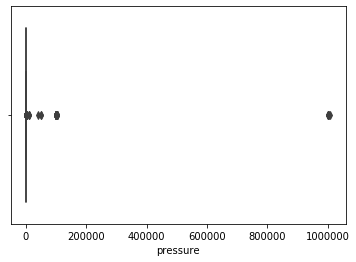

In [26]:
sns.boxplot(x=weather['pressure'])

In [27]:
weather.loc[weather.pressure > 1051, 'pressure'] = np.nan
weather.loc[weather.pressure < 931, 'pressure'] = np.nan

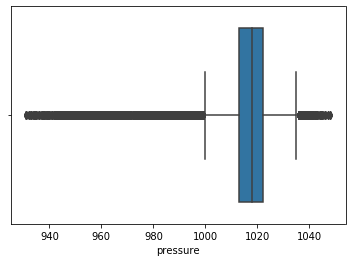

In [28]:
sns.boxplot(x=weather['pressure'])

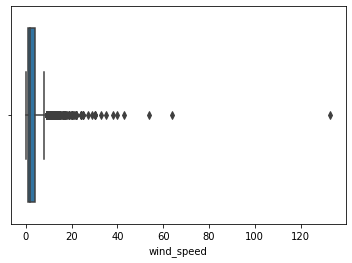

In [29]:
sns.boxplot(x=weather['wind_speed'])


In [30]:
weather.loc[weather.wind_speed > 50, 'wind_speed'] = np.nan

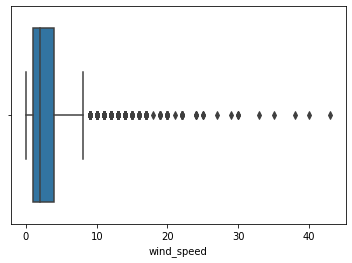

In [31]:
sns.boxplot(x=weather['wind_speed'])

In [32]:
weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

C:\Users\Aditya\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()
C:\Users\Aditya\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


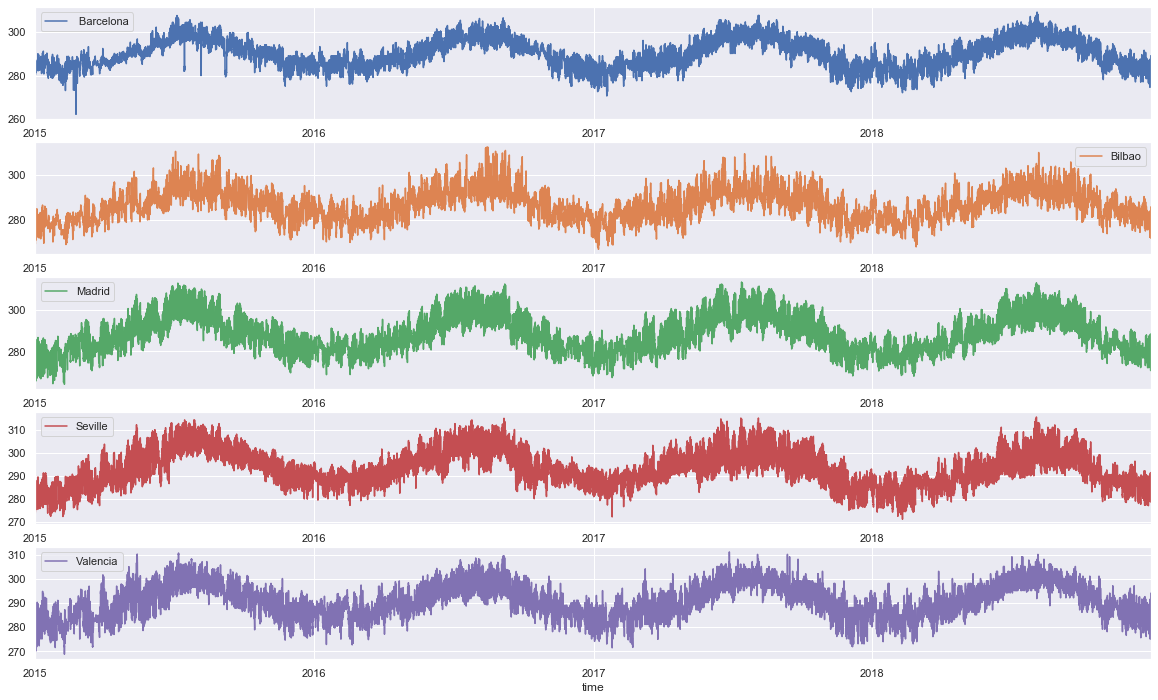

In [33]:
temp_by_city = weather.pivot_table('temp', index='time', columns='city_name', aggfunc='mean')

sns.set()
fig, ax = plt.subplots(figsize=(20, 12))
temp_by_city.plot(ax=ax, subplots=True)
plt.show()

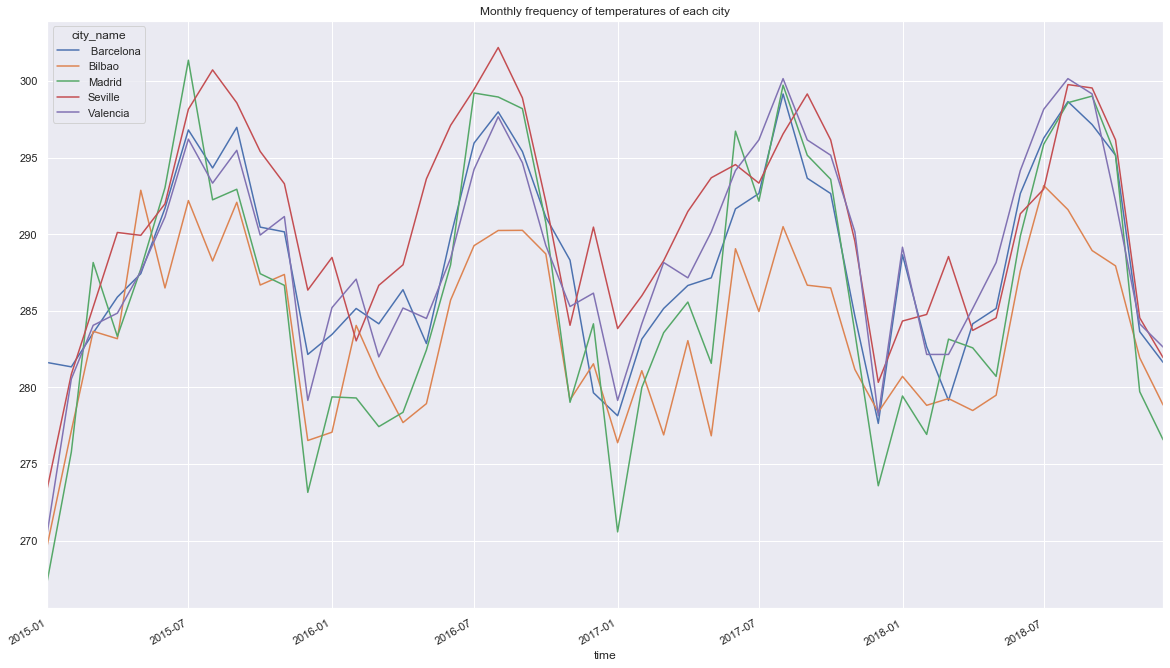

In [34]:
sns.set()
fig, ax = plt.subplots(figsize=(20, 12))
temp_by_city.asfreq('M').plot(ax=ax, title='Monthly frequency of temperatures of each city')
plt.show()

In [35]:
def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe and which
    constitutes one of its columns or it a custom pandas series created by the user.
    The user can define either the 'df' and the 'column' or the 'series' and additionally,
    can also define the 'label', the 'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

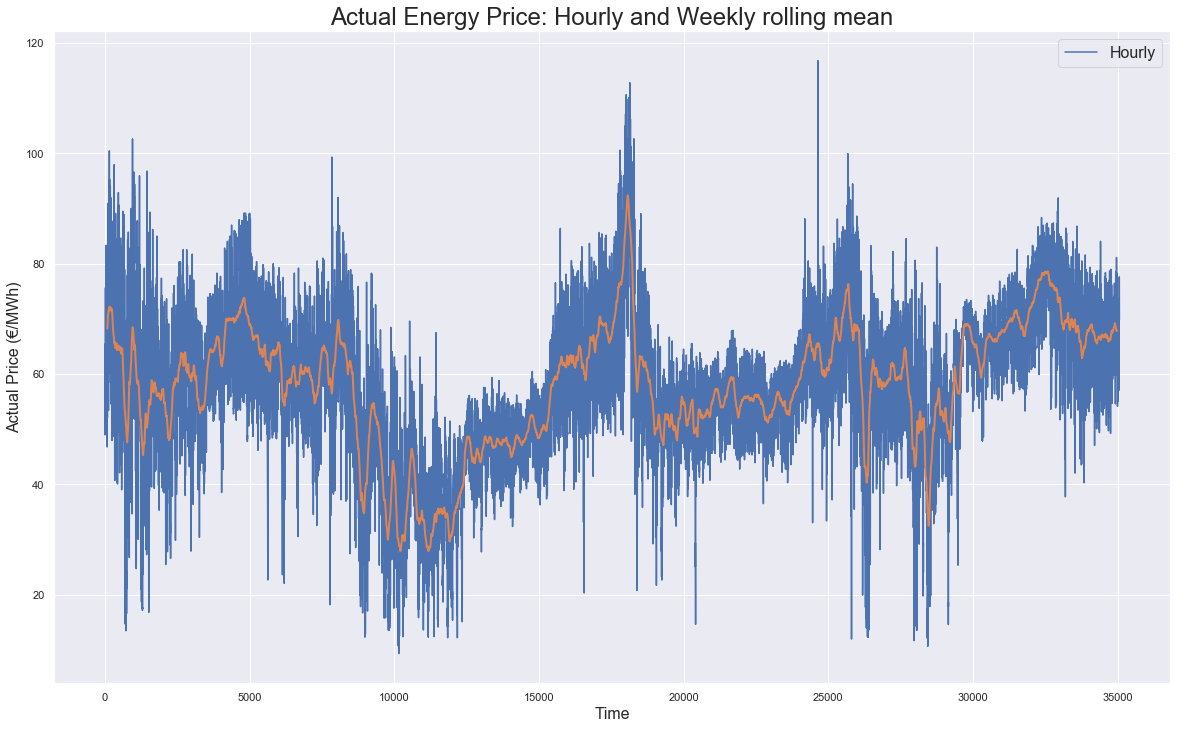

In [36]:
rolling = energy['price actual'].rolling(24*7, center=True).mean()

ax = plot_series(energy, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Energy Price: Hourly and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

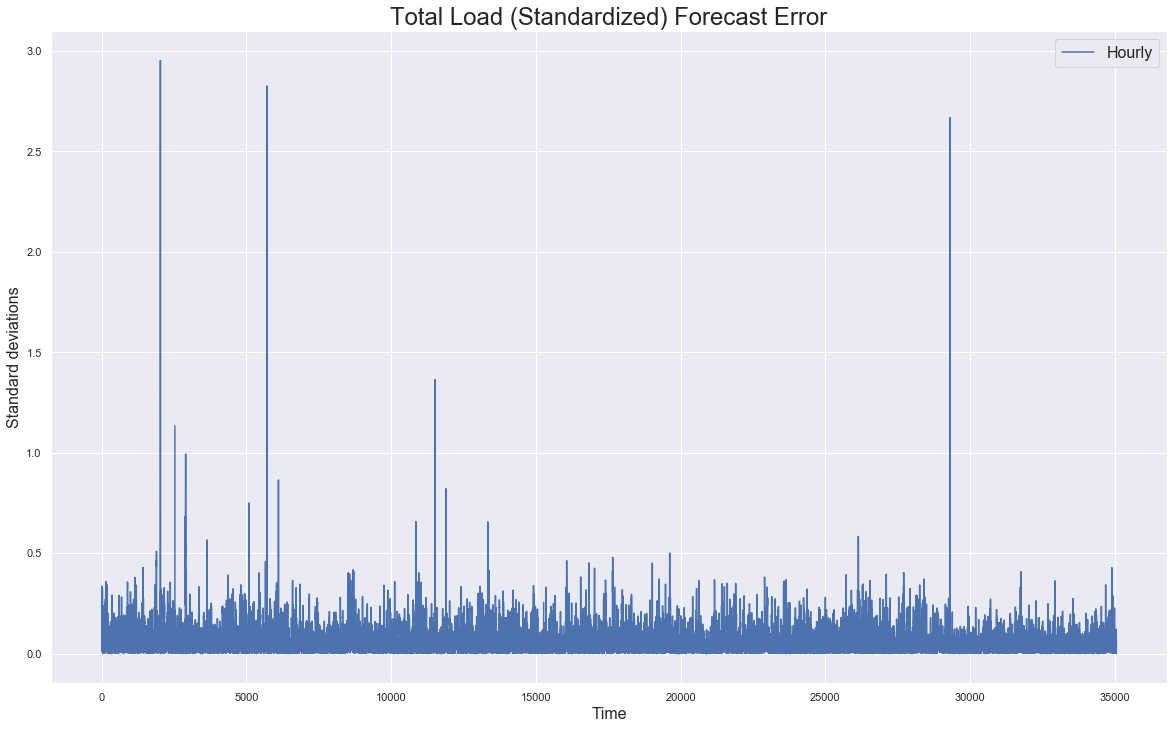

In [37]:
error_load = abs(energy['total load actual'] - energy['total load forecast'])
standardized_error_load = error_load / (energy['total load actual'].std())

ax = plot_series(series=standardized_error_load, label='Hourly', ylabel='Standard deviations',
                 title='Total Load (Standardized) Forecast Error')
plt.show()

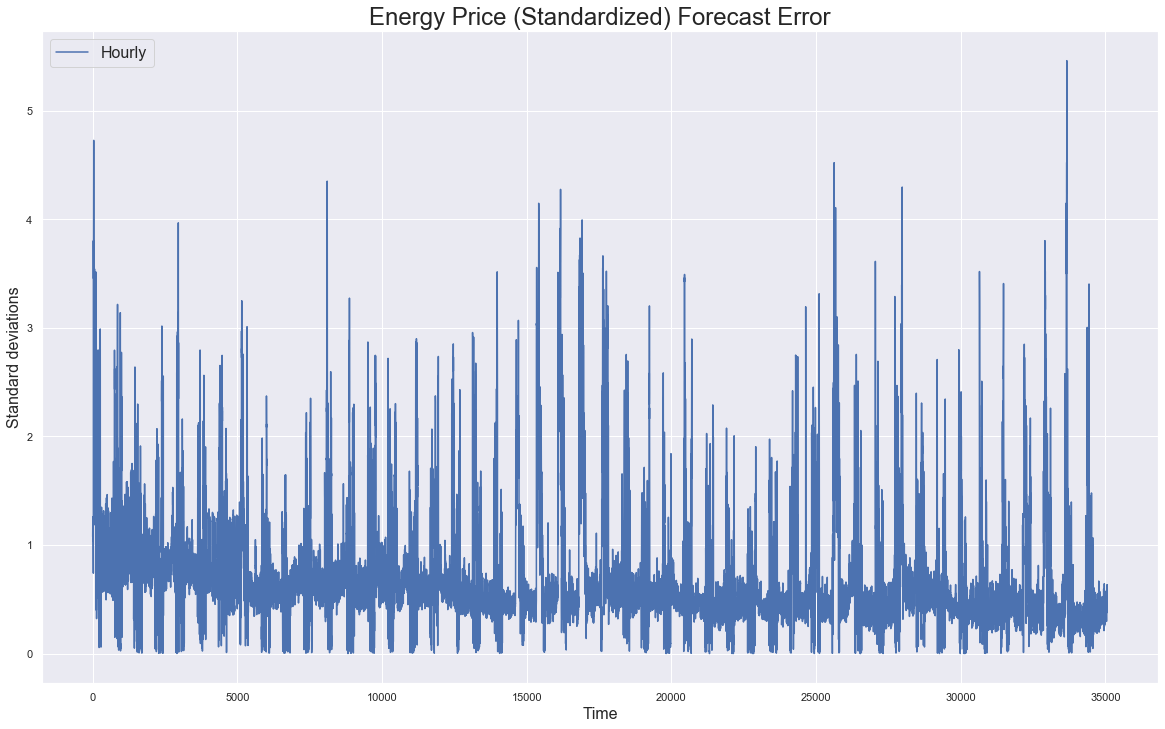

In [38]:
error_price = abs(energy['price actual'] - energy['price day ahead'])
standardized_error_price = error_price / (energy['price actual'].std())

ax = plot_series(series=standardized_error_price, label='Hourly', 
                 ylabel='Standard deviations', title='Energy Price (Standardized) Forecast Error')
plt.show()

In [39]:
energy = energy.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead'], 
                            axis=1)

In [40]:
energy['time'] = pd.to_datetime(energy['time'], utc=True, infer_datetime_format=True)
energy = energy.set_index('time')

In [41]:
print('There are {} missing values or NaNs in df_energy.'.format(energy.isnull().values.sum()))

temp_energy = energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy (except first occurrence) based on all columns.'
      .format(temp_energy))

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy (except first occurrence) based on all columns.


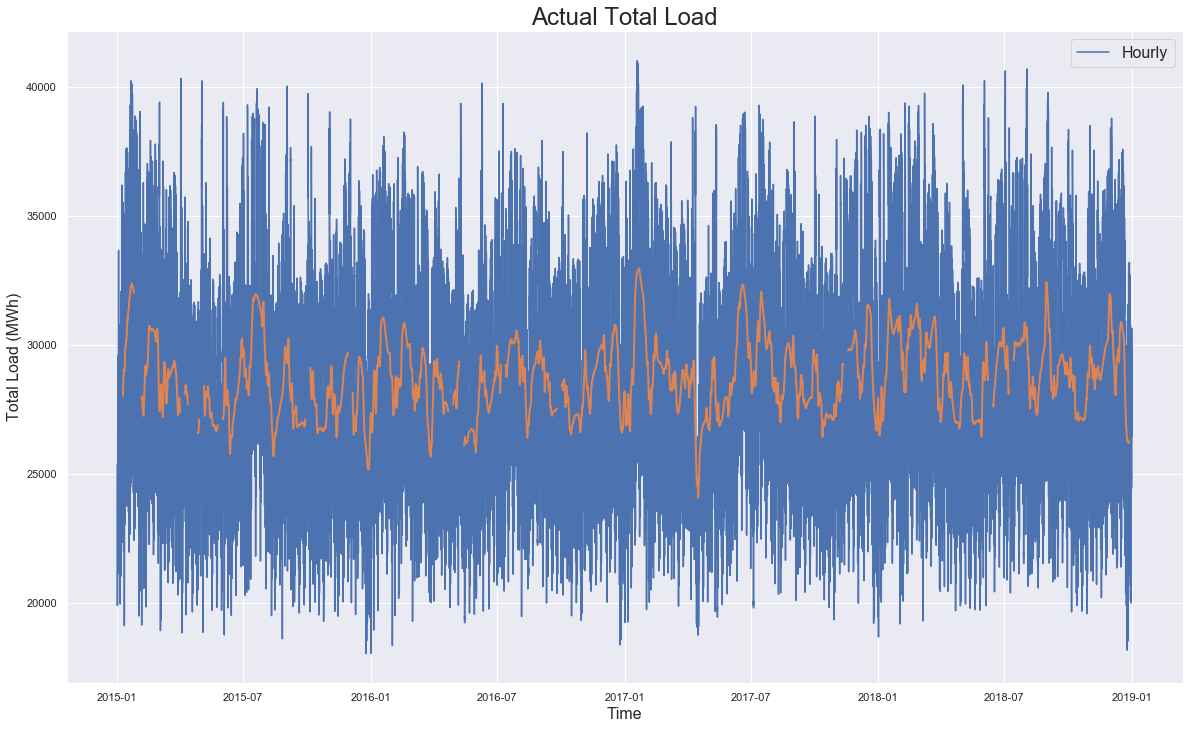

In [42]:
rolling = energy['total load actual'].rolling(24*7, center=True).mean()

ax = plot_series(df=energy, column='total load actual', label='Hourly', 
                 ylabel='Total Load (MWh)', title='Actual Total Load')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

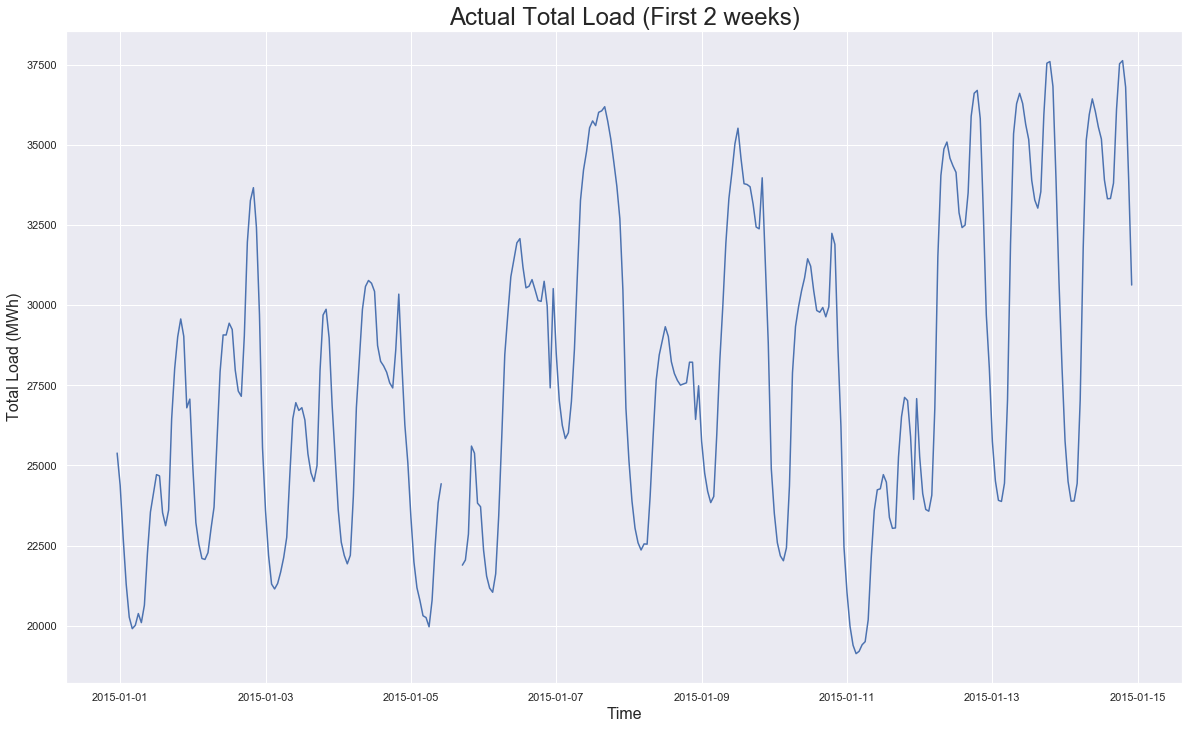

In [43]:
ax = plot_series(df=energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks)', end=24*7*2)
plt.show()

In [44]:
energy[energy.isnull().any(axis=1)]

generation biomass  \
time                                            
2015-01-05 02:00:00+00:00                 NaN   
2015-01-05 11:00:00+00:00                 NaN   
2015-01-05 12:00:00+00:00                 NaN   
2015-01-05 13:00:00+00:00                 NaN   
2015-01-05 14:00:00+00:00                 NaN   
2015-01-05 15:00:00+00:00                 NaN   
2015-01-05 16:00:00+00:00                 NaN   
2015-01-19 18:00:00+00:00                 NaN   
2015-01-19 19:00:00+00:00                 NaN   
2015-01-27 18:00:00+00:00                 NaN   
2015-01-28 12:00:00+00:00                 NaN   
2015-02-01 06:00:00+00:00               449.0   
2015-02-01 07:00:00+00:00               453.0   
2015-02-01 08:00:00+00:00               452.0   
2015-02-01 11:00:00+00:00               405.0   
2015-02-01 12:00:00+00:00               402.0   
2015-02-01 13:00:00+00:00               400.0   
2015-02-01 14:00:00+00:00               393.0   
2015-02-01 15:00:00+00:00               413.0   
2015-02-01 16:00:00+00:00               465.0   
2015-02-01 17:00:00+00:00               482.0   
2015-02-01 18:00:00+00:00               474.0   
2015-04-05 01:00:00+00:00               371.0   
2015-04-16 07:00:00+00:00                 NaN   
2015-04-20 06:00:00+00:00               424.0   
2015-04-23 19:00:00+00:00                 NaN   
2015-05-02 08:00:00+00:00               497.0   
2015-05-29 01:00:00+00:00               569.0   
2015-06-15 07:00:00+00:00                 NaN   
2015-10-02 06:00:00+00:00               483.0   
2015-10-02 09:00:00+00:00                 NaN   
2015-12-02 08:00:00+00:00                 NaN   
2016-04-13 03:00:00+00:00               220.0   
2016-04-25 03:00:00+00:00               190.0   
2016-04-25 05:00:00+00:00               206.0   
2016-05-10 21:00:00+00:00               348.0   
2016-06-11 23:00:00+00:00               356.0   
2016-07-09 20:00:00+00:00                 NaN   
2016-07-11 22:00:00+00:00               346.0   
2016-09-28 07:00:00+00:00               347.0   
2016-10-27 21:00:00+00:00               351.0   
2016-11-23 03:00:00+00:00                 NaN   
2017-11-14 11:00:00+00:00                 0.0   
2017-11-14 18:00:00+00:00                 0.0   
2018-06-11 16:00:00+00:00               331.0   
2018-07-11 07:00:00+00:00                 NaN   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-05 02:00:00+00:00                                   NaN   
2015-01-05 11:00:00+00:00                                   NaN   
2015-01-05 12:00:00+00:00                                   NaN   
2015-01-05 13:00:00+00:00                                   NaN   
2015-01-05 14:00:00+00:00                                   NaN   
2015-01-05 15:00:00+00:00                                   NaN   
2015-01-05 16:00:00+00:00                                   NaN   
2015-01-19 18:00:00+00:00                                   NaN   
2015-01-19 19:00:00+00:00                                   NaN   
2015-01-27 18:00:00+00:00                                   NaN   
2015-01-28 12:00:00+00:00                                   NaN   
2015-02-01 06:00:00+00:00                                 312.0   
2015-02-01 07:00:00+00:00                                 312.0   
2015-02-01 08:00:00+00:00                                 302.0   
2015-02-01 11:00:00+00:00                                 317.0   
2015-02-01 12:00:00+00:00                                 317.0   
2015-02-01 13:00:00+00:00                                 317.0   
2015-02-01 14:00:00+00:00                                 321.0   
2015-02-01 15:00:00+00:00                                 325.0   
2015-02-01 16:00:00+00:00                                 321.0   
2015-02-01 17:00:00+00:00                                 326.0   
2015-02-01 18:00:00+00:00                                 326.0   
2015-04-05 01:00:00+00:00                                   0.0   

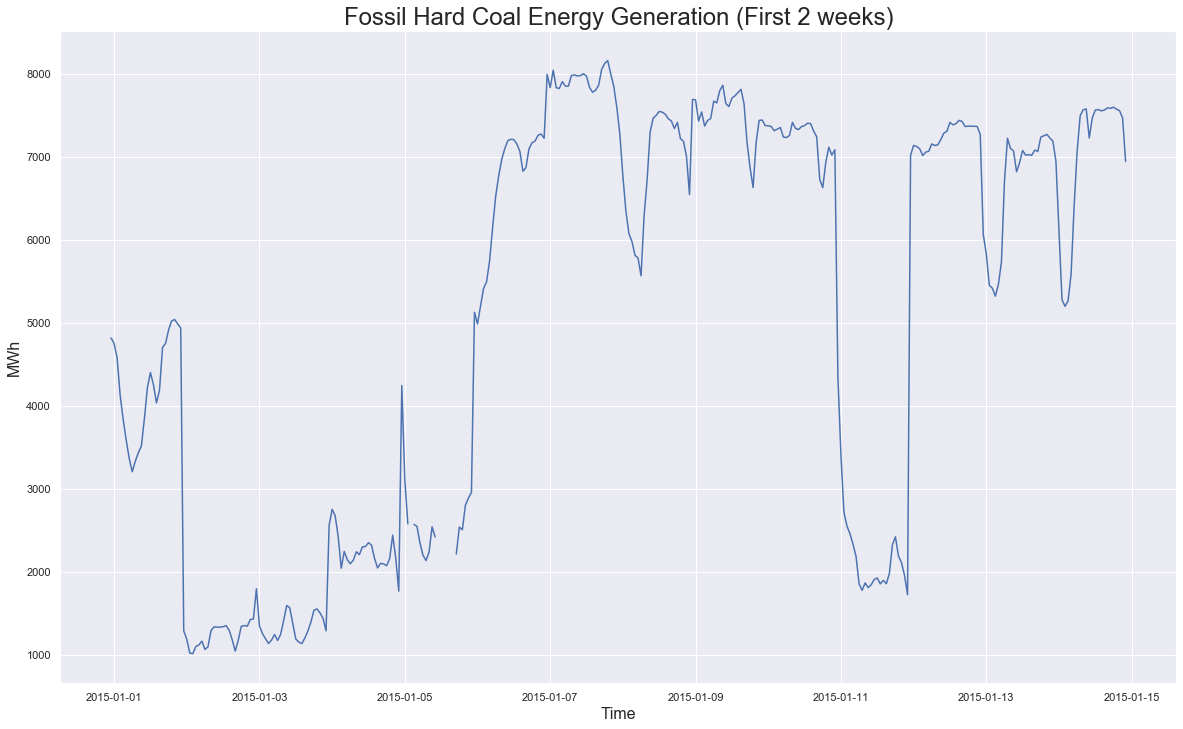

In [45]:
ax = plot_series(df=energy, column='generation fossil hard coal', ylabel='MWh',
                 title='Fossil Hard Coal Energy Generation (First 2 weeks)', end=24*7*2)
plt.show()

In [46]:
energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [47]:
df_1, df_2, df_3, df_4, df_5 = [x for _, x in weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [48]:
df_final = energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)
    
df_final.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp_Barcelona', 'temp_min_Barcelona',
       'temp_max_Barcelona', 'pressure_Barcelona', 'humidity_Barcelona',
       'wind_speed_Barcelona', 'wind_deg_Barcelona', 'rain_1h_Barcelona',
       'rain_3h_Barcelona', 'snow_3h_Barcelona', 'clouds_all_Barcelona',
       'weather_description_Barcelona', 'temp_Bilbao', 'temp_min_Bilbao',
       'temp_max_Bilbao', 'pressure_Bilbao'

In [49]:
df_final

generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   
...                                       ...   
2018-12-31 18:00:00+00:00               297.0   
2018-12-31 19:00:00+00:00               296.0   
2018-12-31 20:00:00+00:00               292.0   
2018-12-31 21:00:00+00:00               293.0   
2018-12-31 22:00:00+00:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   
...                                                         ...   
2018-12-31 18:00:00+00:00                                   0.0   
2018-12-31 19:00:00+00:00                                   0.0   
2018-12-31 20:00:00+00:00                                   0.0   
2018-12-31 21:00:00+00:00                                   0.0   
2018-12-31 22:00:00+00:00                                   0.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2014-12-31 23:00:00+00:00                 4844.0                       4821.0   
2015-01-01 00:00:00+00:00                 5196.0                       4755.0   
2015-01-01 01:00:00+00:00                 4857.0                       4581.0   
2015-01-01 02:00:00+00:00                 4314.0                       4131.0   
2015-01-01 03:00:00+00:00                 4130.0                       3840.0   
...                                          ...                          ...   
2018-12-31 18:00:00+00:00                 7634.0                       2628.0   
2018-12-31 19:00:00+00:00                 7241.0                       2566.0   
2018-12-31 20:00:00+00:00                 7025.0                       2422.0   
2018-12-31 21:00:00+00:00                 6562.0                       2293.0   
2018-12-31 22:00:00+00:00                 6926.0                       2166.0   

                           generation fossil oil  \
time                                               
2014-12-31 23:00:00+00:00                  162.0   
2015-01-01 00:00:00+00:00                  158.0   
2015-01-01 01:00:00+00:00                  157.0   
2015-01-01 02:00:00+00:00                  160.0   
2015-01-01 03:00:00+00:00                  156.0   
...                                          ...   
2018-12-31 18:00:00+00:00                  178.0   
2018-12-31 19:00:00+00:00                  174.0   
2018-12-31 20:00:00+00:00                  168.0   
2018-12-31 21:00:00+00:00                  163.0   
2018-12-31 22:00:00+00:00                  163.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2014-12-31 23:00:00+00:00                                        863.0   
2015-01-01 00:00:00+00:00                                        920.0   
2015-01-01 01:00:00+00:00                                       1164.0   
2015-01-01 02:00:00+00:00                                       1503.0   
2015-01-01 03:00:00+00:00                                       1826.0   
...                                                                ...   
2018-12-31 18:00:00+00:00                                          1.0   
2018-12-31 19:00:00+00:00                                          1.0   
2018-12-31 20:00:00+00:00                     

In [49]:
def rmse(actual, forecast, string):
    mse = mean_squared_error(actual, forecast)
    rmse = sqrt(mse)
    st_dev = actual.std()
    ratio = rmse / st_dev
    print('\nRMSE of {}: {}'.format(string, round(rmse, 3)))
    print(' For comparison, the standard deviation of {} is: {}'.format(string, round(st_dev), 3))
    print('  The RMSE / standard deviation ratio of {} is: {}'.format(string, round(ratio, 3)))

In [50]:
rmse(df_final['total load actual'], df_final['total load forecast'], 'total load')
rmse(df_final['price actual'], df_final['price day ahead'], 'price')


RMSE of total load: 454.651
 For comparison, the standard deviation of total load is: 4576
  The RMSE / standard deviation ratio of total load is: 0.099

RMSE of price: 13.25
 For comparison, the standard deviation of price is: 14
  The RMSE / standard deviation ratio of price is: 0.933


In [51]:
df_final.head()

generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2014-12-31 23:00:00+00:00                 4844.0                       4821.0   
2015-01-01 00:00:00+00:00                 5196.0                       4755.0   
2015-01-01 01:00:00+00:00                 4857.0                       4581.0   
2015-01-01 02:00:00+00:00                 4314.0                       4131.0   
2015-01-01 03:00:00+00:00                 4130.0                       3840.0   

                           generation fossil oil  \
time                                               
2014-12-31 23:00:00+00:00                  162.0   
2015-01-01 00:00:00+00:00                  158.0   
2015-01-01 01:00:00+00:00                  157.0   
2015-01-01 02:00:00+00:00                  160.0   
2015-01-01 03:00:00+00:00                  156.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2014-12-31 23:00:00+00:00                                        863.0   
2015-01-01 00:00:00+00:00                                        920.0   
2015-01-01 01:00:00+00:00                                       1164.0   
2015-01-01 02:00:00+00:00                                       1503.0   
2015-01-01 03:00:00+00:00                                       1826.0   

                           generation hydro run-of-river and poundage  \
time                                                                    
2014-12-31 23:00:00+00:00                                      1051.0   
2015-01-01 00:00:00+00:00                                      1009.0   
2015-01-01 01:00:00+00:00                                       973.0   
2015-01-01 02:00:00+00:00                                       949.0   
2015-01-01 03:00:00+00:00                                       953.0   

                           generation hydro water reservoir  \
time                                                          
2014-12-31 23:00:00+00:00                            1899.0   
2015-01-01 00:00:00+00:00                            1658.0   
2015-01-01 01:00:00+00:00                            1371.0   
2015-01-01 02:00:00+00:00                             779.0   
2015-01-01 03:00:00+00:00                             720.0   

                           generation nuclear  generation other  ...  \
time                                                             ...   
2014-12-31 23:00:00+00:00              7096.0              43.0  ...   
2015-01-01 00:00:00+00:00              7096.0              43.0  ...   
2015-01-01 01:00:00+00:00              7099.0              43.0  ...   
2015-01-01 02:00:00+00:00              7098.0              43.0  ...   
2015-01-01 03:00:00+00:00              7097.0              43.0  ...   

                           temp_max_Valencia  pressure_Valencia  \
time                                                              
2014-12-31 23:00:00+00:00            270.475             1001.0   
2015-01-01 00:00:00+00:00            270.475             1001.0   
2015-01-01 01:00:00+00:00         

In [52]:
df_final.interpolate(limit_direction='forward', inplace=True, axis=0)
df_final = df_final.drop_duplicates()

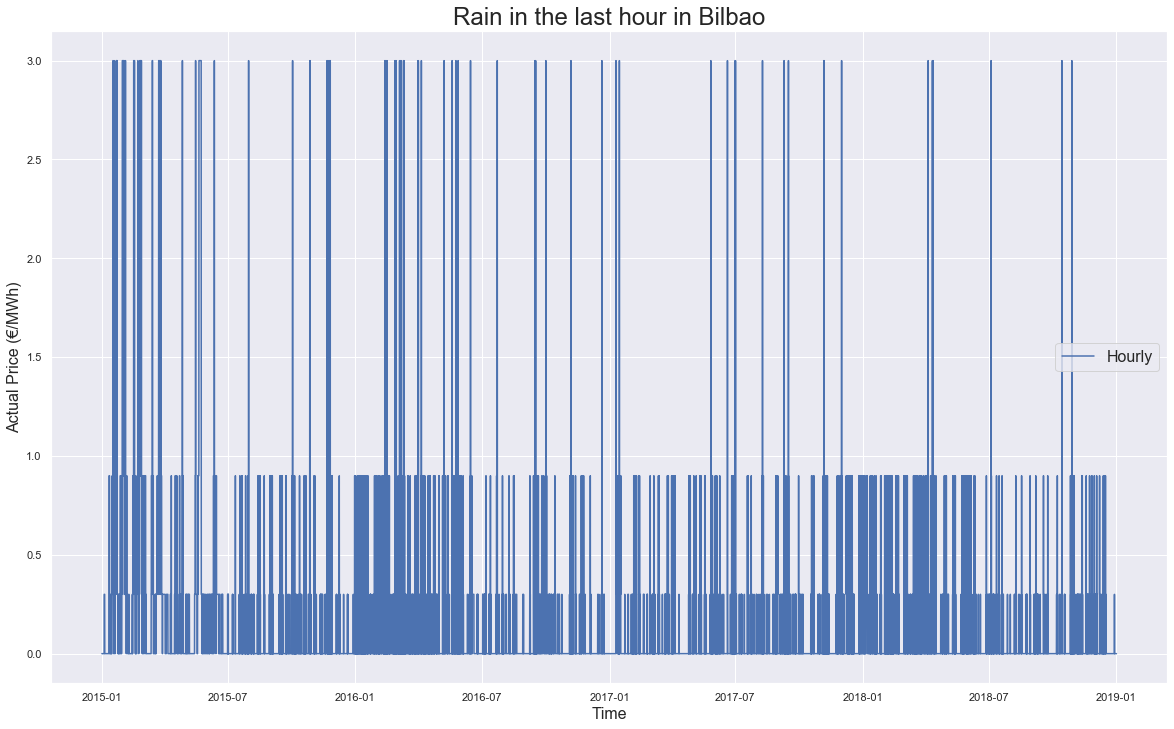

In [53]:
ax = plot_series(df_final, 'rain_1h_Bilbao', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Rain in the last hour in Bilbao')
plt.show()

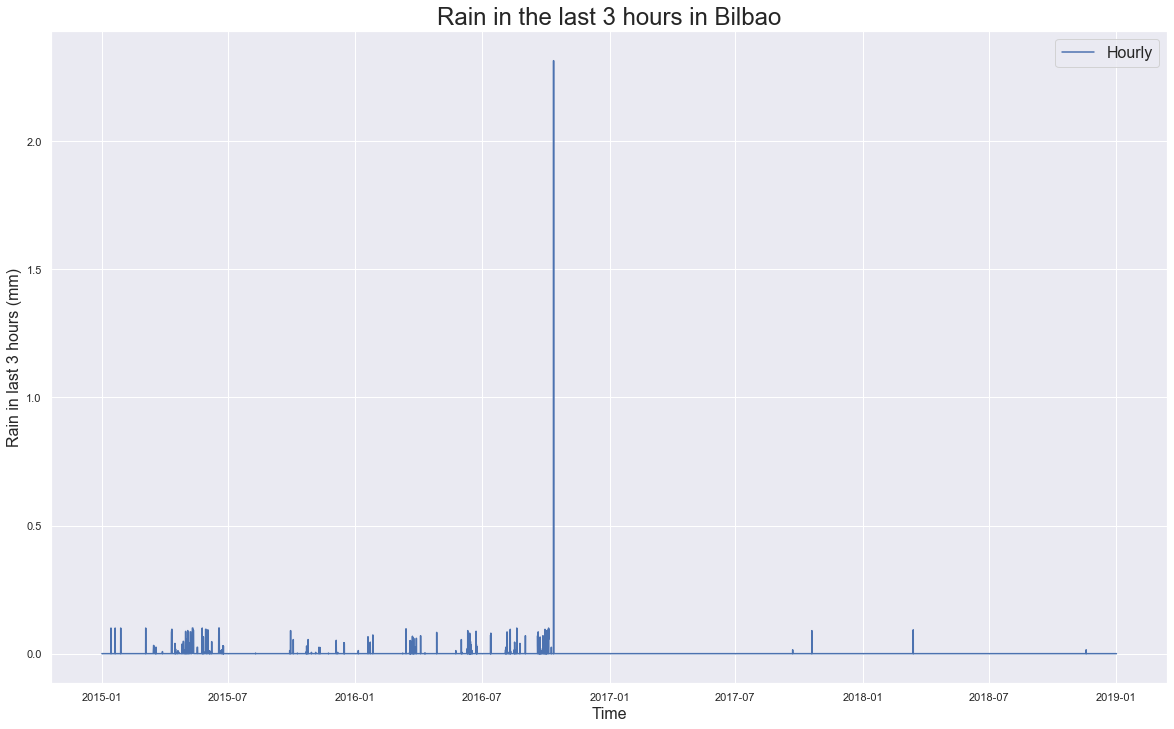

In [54]:
ax = plot_series(df_final, 'rain_3h_Bilbao', label='Hourly', ylabel='Rain in last 3 hours (mm)',
                 title='Rain in the last 3 hours in Bilbao')
plt.show()

In [55]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in cities:
    df_final = df_final.drop(['rain_3h_{}'.format(city)], axis=1)

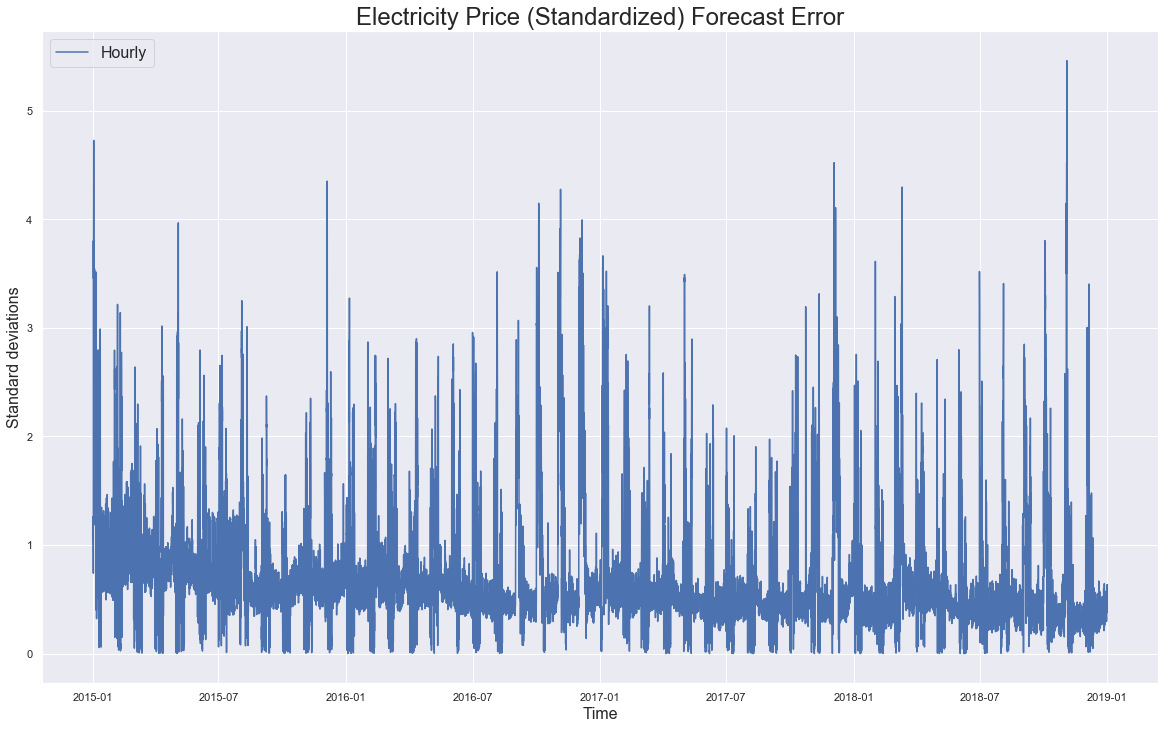

In [56]:
error_price = abs(df_final['price actual'] - df_final['price day ahead'])
standardized_error_price = error_price / (df_final['price actual'].std())
ax = plot_series(series=standardized_error_price, label='Hourly', 
                 ylabel='Standard deviations', title='Electricity Price (Standardized) Forecast Error')
plt.show()

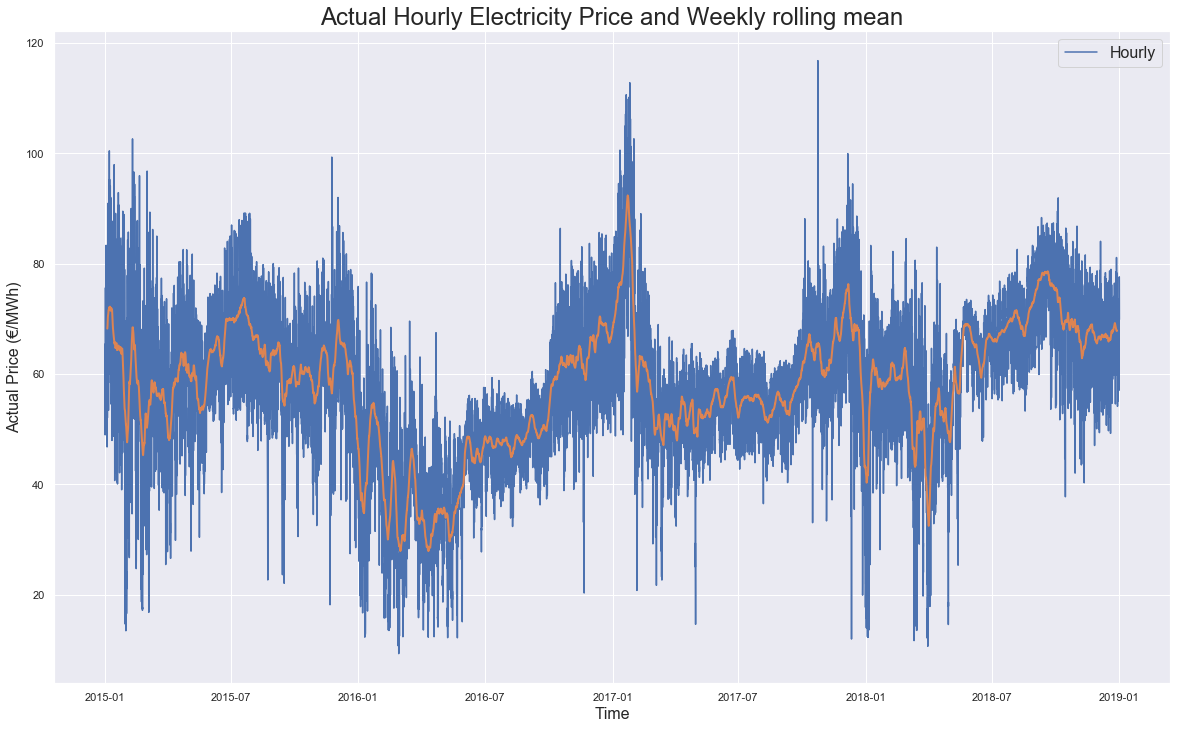

In [57]:
rolling = df_final['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from math import sqrt

In [59]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [60]:
tf.random.set_seed(42)
np.random.seed(42)
tf.keras.backend.set_floatx('float32')

sns.set()

In [61]:
y = df_final['price actual']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -9.147016
p-value: 0.000000
#Lags used: 50
Critical Value (1%): -3.430537
Critical Value (5%): -2.861623
Critical Value (10%): -2.566814


In [62]:
kpss_test = kpss(y, regression='c', lags='legacy')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 7.957007
p-value: 0.010000
#Lags used: 52
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


C:\Users\Aditya\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


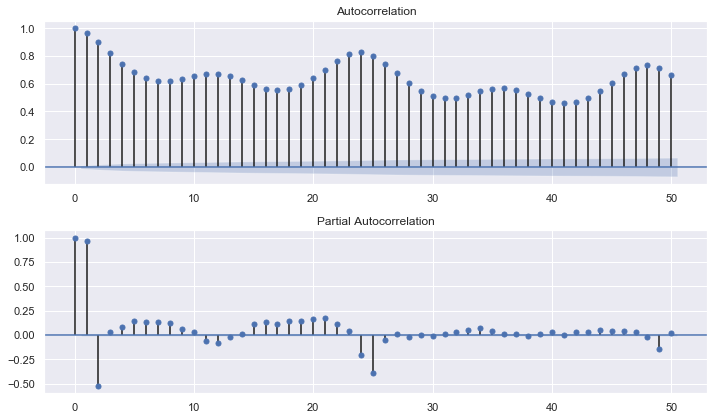

In [63]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_final['price actual'], lags=50, ax=ax1)
plot_pacf(df_final['price actual'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

In [64]:
correlations = df_final.corr(method='pearson')
print(correlations['total load actual'].sort_values(ascending=False).to_string())

total load actual                              1.000000
total load forecast                            0.995096
generation fossil gas                          0.548986
generation fossil oil                          0.496139
generation hydro water reservoir               0.479491
price day ahead                                0.474273
price actual                                   0.435253
forecast solar day ahead                       0.403835
generation fossil hard coal                    0.397079
generation solar                               0.395511
generation fossil brown coal/lignite           0.280735
temp_min_Valencia                              0.235297
temp_Valencia                                  0.220790
temp_min_Seville                               0.206488
temp_max_Madrid                                0.204718
temp_Seville                                   0.204571
temp_max_Valencia                              0.199833
temp_Bilbao                                    0

In [67]:
df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)

KeyError: "['snow_3h_Barcelona' 'snow_3h_Seville'] not found in axis"

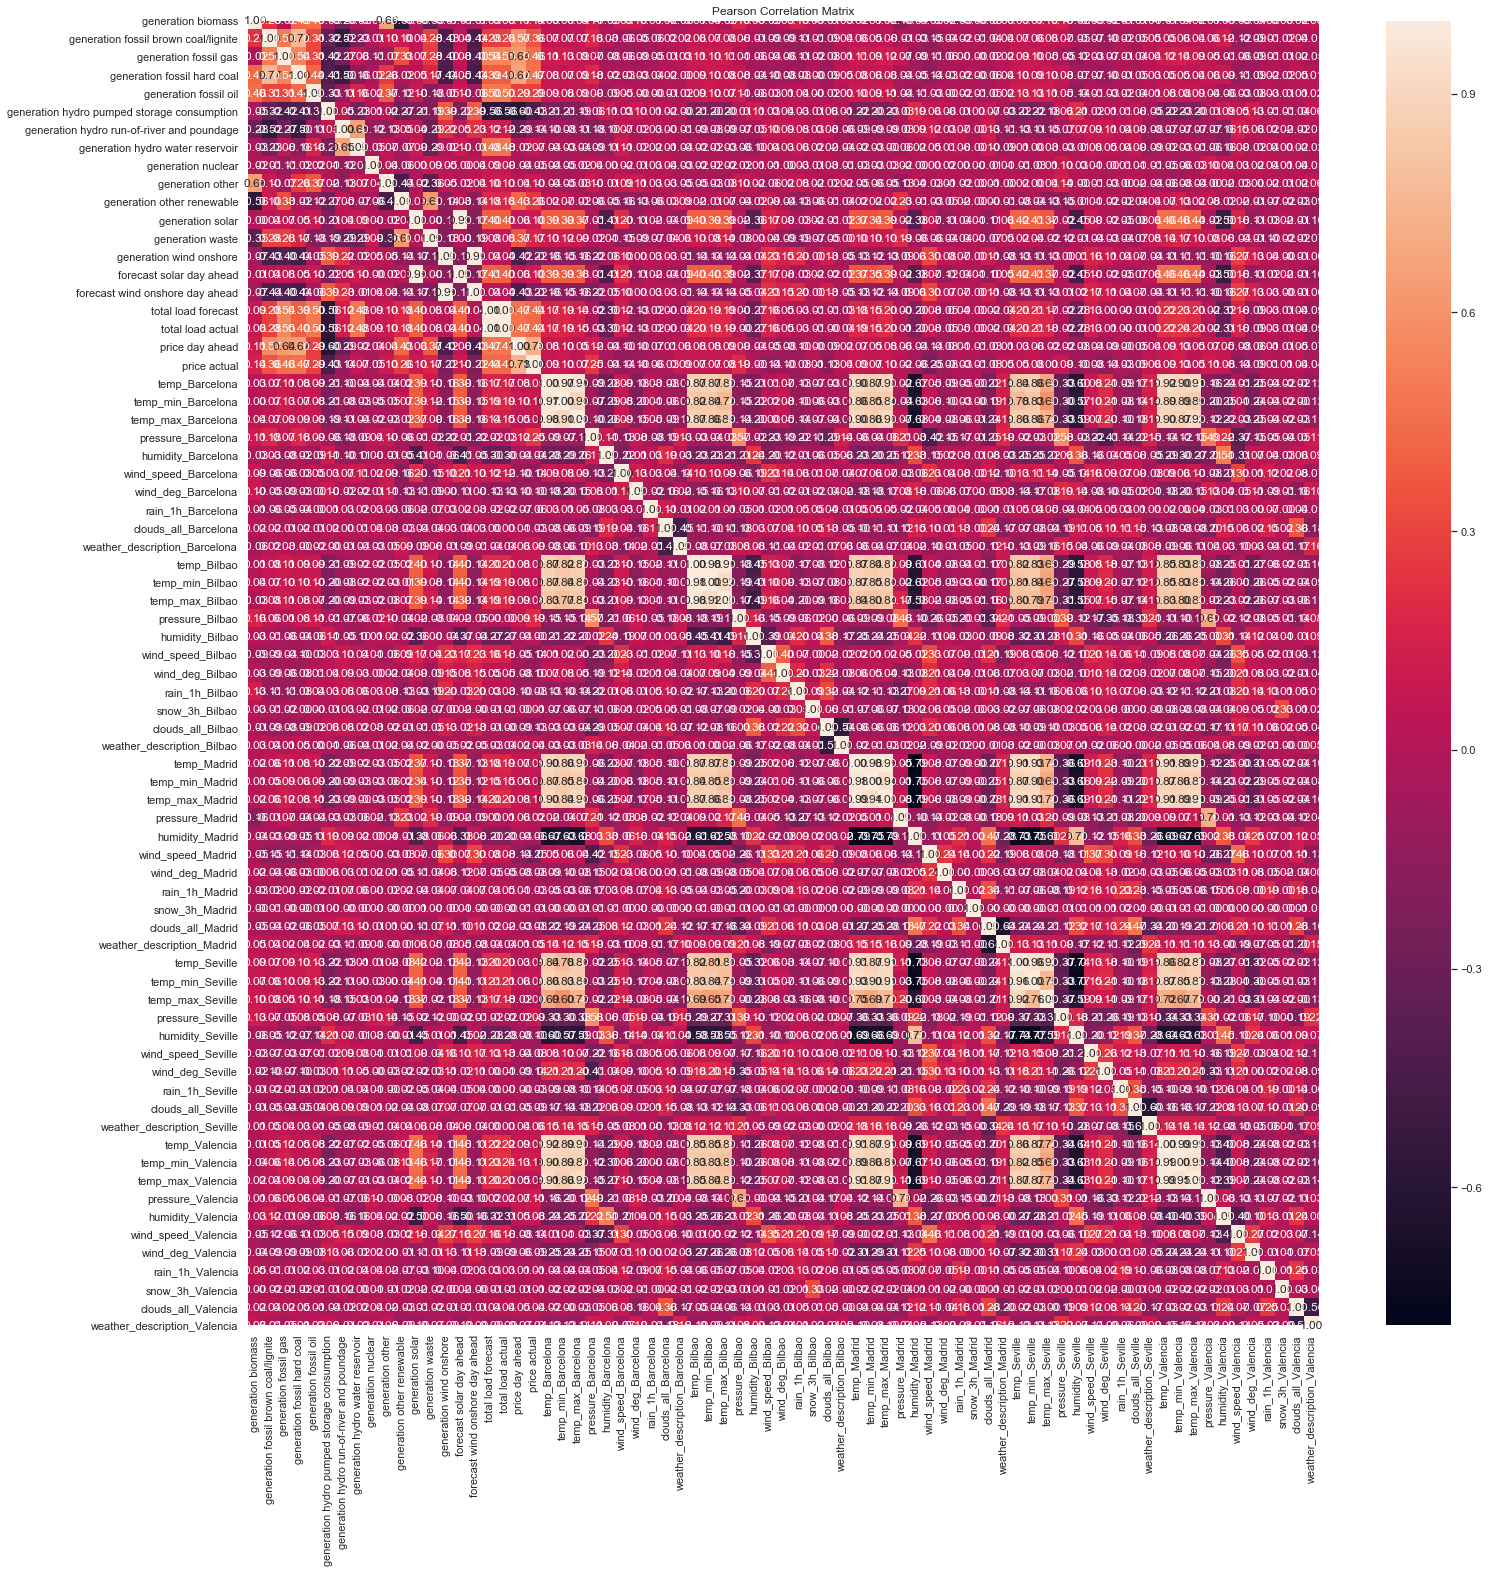

In [68]:
correlations = df_final.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [69]:
highly_correlated = abs(correlations[correlations > 0.70])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

generation fossil brown coal/lignite  generation fossil hard coal             0.768831
generation fossil hard coal           generation fossil brown coal/lignite    0.768831
generation solar                      forecast solar day ahead                0.993244
generation wind onshore               forecast wind onshore day ahead         0.994457
forecast solar day ahead              generation solar                        0.993244
forecast wind onshore day ahead       generation wind onshore                 0.994457
total load forecast                   total load actual                       0.995096
total load actual                     total load forecast                     0.995096
price day ahead                       price actual                            0.732155
price actual                          price day ahead                         0.732155
temp_Barcelona                        temp_min_Barcelona                      0.970264
                                      temp_

In [70]:
for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month

In [71]:
for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0

In [72]:
# Generate 'weekend' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

In [73]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for i in range(len(df_final)):
    position = df_final.index[i]
    for city in cities:
        temp_max = df_final.loc[position, 'temp_max_{}'.format(city)]
        temp_min = df_final.loc[position, 'temp_min_{}'.format(city)]
        df_final.loc[position, 'temp_range_{}'.format(city)] = abs(temp_max - temp_min)

In [74]:
total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000

weight_Madrid = 6155116 / total_pop
weight_Barcelona = 5179243 / total_pop
weight_Valencia = 1645342 / total_pop
weight_Seville = 1305342 / total_pop
weight_Bilbao = 987000 / total_pop

In [75]:
cities_weights = {'Madrid': weight_Madrid, 
                  'Barcelona': weight_Barcelona,
                  'Valencia': weight_Valencia,
                  'Seville': weight_Seville,
                  'Bilbao': weight_Bilbao}

In [76]:
for i in range(len(df_final)):
    position = df_final.index[i]
    temp_weighted = 0
    for city in cities:
        temp = df_final.loc[position, 'temp_{}'.format(city)]
        temp_weighted += temp * cities_weights.get('{}'.format(city))
    df_final.loc[position, 'temp_weighted'] = temp_weighted

In [77]:
df_final['generation coal all'] = df_final['generation fossil hard coal'] + df_final['generation fossil brown coal/lignite']

In [78]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

df_train = df_final[:27048]

df_cv = df_final[27048:31056]

In [79]:
y_train = df_train['total load actual'].values
y_cv = df_cv['total load actual'].values
y_train = y_train.reshape(-1, 1)
y_cv = y_cv.reshape(-1, 1)

X_train = df_train.drop(['total load actual', 'total load forecast'], axis=1)
X_cv = df_cv.drop(['total load actual', 'total load forecast'], axis=1)
names = X_train.columns.values

In [80]:
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_mult = MinMaxScaler(feature_range=(0, 1))

scaler_price.fit(y_train)
scaler_price.transform(y_train)
scaler_price.transform(y_cv)

scaler_mult.fit(X_train)
scaler_mult.transform(X_train)
scaler_mult.transform(X_cv)

array([[0.46114865, 0.        , 0.1286455 , ..., 0.        , 0.24125595,
        0.10976395],
       [0.44932432, 0.        , 0.12070642, ..., 0.        , 0.21608864,
        0.10804721],
       [0.4527027 , 0.        , 0.11860013, ..., 0.        , 0.18247671,
        0.11083691],
       ...,
       [0.55743243, 0.63763764, 0.20549795, ..., 0.        , 0.80393329,
        0.61255365],
       [0.55067568, 0.63863864, 0.19944913, ..., 0.        , 0.74280754,
        0.59935622],
       [0.5625    , 0.64564565, 0.17298553, ..., 0.        , 0.7203311 ,
        0.5833691 ]])

In [81]:
param = {'eta': 0.03, 'max_depth': 2, 
         'subsample': 1.0, 'colsample_bytree': 0.80, 
         'alpha': 1.5, 'lambda': 1.5, 'gamma': 1.5,
         'objective': 'reg:linear', 'eval_metric': 'rmse', 
         'silent': 1, 'min_child_weight': 5, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
dtest = xgb.DMatrix(X_cv, y_cv, feature_names=X_cv.columns.values)
eval_list = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model = xgb.train(param, dtrain, 200, eval_list)

[0]	train-rmse:28109.89258	eval-rmse:28481.67578
[1]	train-rmse:27276.68164	eval-rmse:27642.28711
[2]	train-rmse:26468.84570	eval-rmse:26827.34961
[3]	train-rmse:25685.30078	eval-rmse:26038.19531
[4]	train-rmse:24925.53516	eval-rmse:25282.16602
[5]	train-rmse:24188.89844	eval-rmse:24553.37109
[6]	train-rmse:23474.17969	eval-rmse:23833.90039
[7]	train-rmse:22781.24023	eval-rmse:23135.28516
[8]	train-rmse:22109.44336	eval-rmse:22464.45703
[9]	train-rmse:21457.82617	eval-rmse:21809.15039
[10]	train-rmse:20826.16992	eval-rmse:21172.36914
[11]	train-rmse:20214.75195	eval-rmse:20535.17773
[12]	train-rmse:19620.68945	eval-rmse:19937.33984
[13]	train-rmse:19044.89648	eval-rmse:19357.04102
[14]	train-rmse:18486.08008	eval-rmse:18804.18555
[15]	train-rmse:17944.73047	eval-rmse:18251.88477
[16]	train-rmse:17419.78711	eval-rmse:17720.32227
[17]	train-rmse:16910.95508	eval-rmse:17196.59180
[18]	train-rmse:16417.13672	eval-rmse:16708.58008
[19]	train-rmse:15938.79981	eval-rmse:16228.57422
[20]	train

[168]	train-rmse:1780.16187	eval-rmse:2016.49255
[169]	train-rmse:1775.04248	eval-rmse:2009.37292
[170]	train-rmse:1770.69348	eval-rmse:2005.06458
[171]	train-rmse:1766.21081	eval-rmse:2002.34131
[172]	train-rmse:1762.28589	eval-rmse:1997.32190
[173]	train-rmse:1757.88745	eval-rmse:1992.24341
[174]	train-rmse:1752.86487	eval-rmse:1985.37402
[175]	train-rmse:1749.25879	eval-rmse:1981.64636
[176]	train-rmse:1746.17664	eval-rmse:1979.38721
[177]	train-rmse:1743.06238	eval-rmse:1975.29736
[178]	train-rmse:1738.82092	eval-rmse:1970.52271
[179]	train-rmse:1734.76294	eval-rmse:1965.37683
[180]	train-rmse:1731.32373	eval-rmse:1963.06042
[181]	train-rmse:1727.59717	eval-rmse:1961.37231
[182]	train-rmse:1723.07568	eval-rmse:1956.67188
[183]	train-rmse:1719.27210	eval-rmse:1952.61890
[184]	train-rmse:1715.56348	eval-rmse:1951.27722
[185]	train-rmse:1712.11169	eval-rmse:1947.25232
[186]	train-rmse:1707.97119	eval-rmse:1941.41675
[187]	train-rmse:1704.82935	eval-rmse:1939.12183
[188]	train-rmse:170

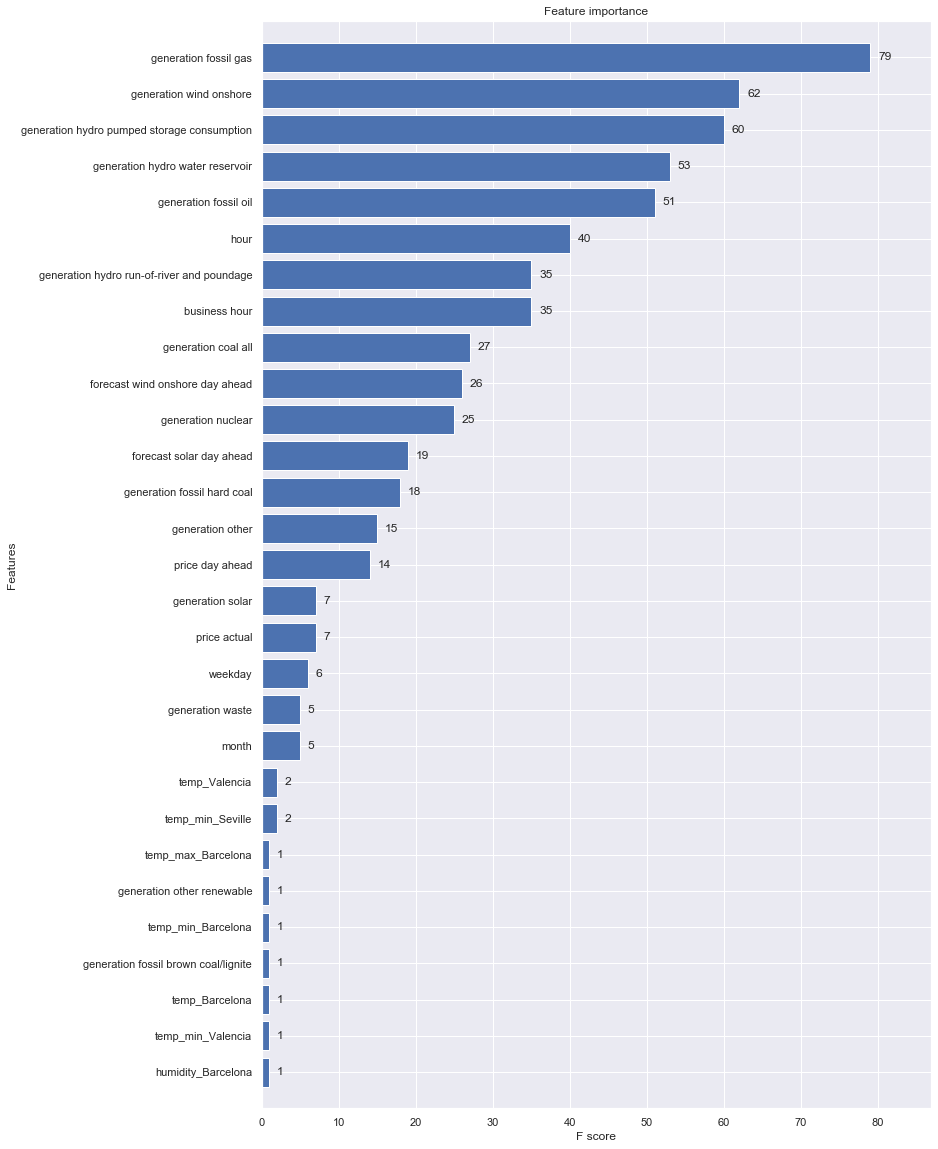

In [82]:
fig, ax = plt.subplots(figsize=(12, 20))
xgb.plot_importance(xgb_model, max_num_features=70, height=0.8, ax=ax)
plt.show()

In [83]:
correlations = df_train.corr(method='pearson')
correlations_price = abs(correlations['total load actual'])
print(correlations_price[correlations_price > 0.20]
      .sort_values(ascending=False).to_string())

total load actual                              1.000000
total load forecast                            0.994685
generation hydro pumped storage consumption    0.582538
business hour                                  0.567591
generation fossil gas                          0.544326
price day ahead                                0.508078
generation fossil oil                          0.493514
generation hydro water reservoir               0.471039
price actual                                   0.450574
generation fossil hard coal                    0.403324
hour                                           0.400249
generation coal all                            0.399434
forecast solar day ahead                       0.392014
generation solar                               0.383287
generation fossil brown coal/lignite           0.303441
humidity_Valencia                              0.303077
humidity_Seville                               0.276949
humidity_Barcelona                             0

In [89]:
considered_features = ['hour', 'business hour','generation wind onshore',
                       'generation hydro pumped storage consumption', 'generation fossil gas',
                       'generation coal all', 'generation other',  
                       'generation hydro run-of-river and poundage', 'generation hydro water reservoir',
                       'generation fossil oil', 'forecast wind onshore day ahead',
                       'generation nuclear', 'forecast solar day ahead',
                       'generation fossil hard coal']

In [90]:
len(considered_features)

14

In [91]:
values = df_final[considered_features].values

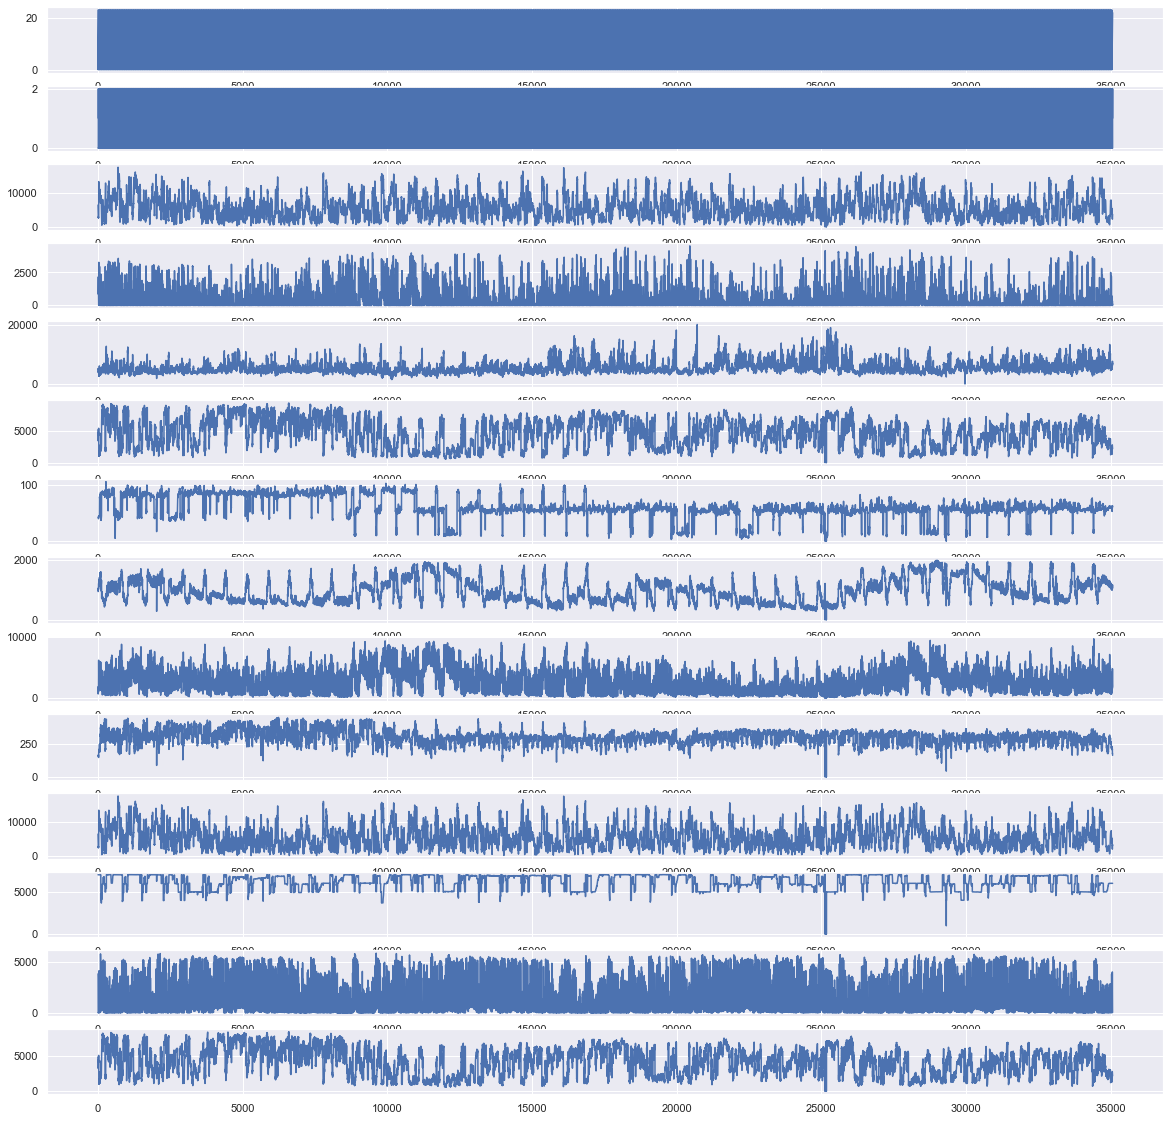

In [92]:
plt.figure(figsize=(20, 20))
for i in range(values.shape[1]):
    plt.subplot(values.shape[1], 1, i+1)
    plt.plot(values[:, i])
plt.show()

In [93]:
for feature in considered_features:
    mean_feat = df_final[feature].mean()
    stdev_feat = df_final[feature].std()
    upper_limit = mean_feat + 4 * stdev_feat
    lower_limit = mean_feat - 4 * stdev_feat
    df_final.loc[df_final[feature] > upper_limit, feature] = np.nan
    df_final.loc[df_final[feature] < lower_limit, feature] = np.nan

In [94]:
df_final[considered_features].isnull().sum()

hour                                             0
business hour                                    0
generation wind onshore                          0
generation hydro pumped storage consumption    178
generation fossil gas                          152
generation coal all                              0
generation other                                 0
generation hydro run-of-river and poundage       0
generation hydro water reservoir                 0
generation fossil oil                            5
forecast wind onshore day ahead                  0
generation nuclear                               4
forecast solar day ahead                         0
generation fossil hard coal                      0
dtype: int64

In [95]:
df_final.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [97]:
y = df_final['total load actual'].values
y_forecast = energy['total load forecast'].values

In [98]:
y_train = y[:27048]
y_cv = y[27048 : 31056]
y_test = y[31056:]

In [102]:
rmse_tso_day = sqrt(mean_squared_error(y_test, y_forecast[31056:]))

print('RMSE of day-ahead load forecast by TSO: {}'.format(round(rmse_tso_day, 3)))

RMSE of day-ahead load forecast by TSO: 347.936


In [101]:
naive_day_ahead = y[31056 - 24 : 35064 - 24]
rmse_naive_day = sqrt(mean_squared_error(y_test, naive_day_ahead))

print('RMSE of day-ahead load naive forecast: {}'.format(round(rmse_naive_day, 3)))

RMSE of day-ahead load naive forecast: 3523.191


In [103]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

In [104]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

In [106]:
def plot_learning_rate_schedule(history_lr, max_loss):
    plt.semilogx(history_lr.history['lr'], history_lr.history['loss'])
    plt.axis([1e-4, 1, 0, max_loss])
    plt.xlabel('Learning Rate')
    plt.ylabel('Training Loss')
    plt.show()

In [107]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

In [108]:
y = df_final['total load actual'].values

In [109]:
scaler = MinMaxScaler(feature_range=(0, 1))
y_reshaped = y.reshape(-1, 1)
scaler.fit(y_reshaped[:train_end_idx])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [110]:
scaled_load = scaler.transform(y_reshaped)

In [112]:
univariate_past_history = 25

In [113]:
univariate_future_target = 0

In [114]:
X_train_univ, y_train_univ = univariate_data(scaled_load, 0, train_end_idx,
                                             univariate_past_history,
                                             univariate_future_target)

In [115]:
X_val_univ, y_val_univ = univariate_data(scaled_load, train_end_idx, cv_end_idx,
                                         univariate_past_history,
                                         univariate_future_target)

In [116]:
X_test_univ, y_test_univ = univariate_data(scaled_load, cv_end_idx, test_end_idx,
                                           univariate_past_history,
                                           univariate_future_target)

In [117]:
batch_size = 32
buffer_size = 1000

In [118]:
train_univ = tf.data.Dataset.from_tensor_slices((X_train_univ, y_train_univ))
train_univ = train_univ.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

In [119]:
val_univ = tf.data.Dataset.from_tensor_slices((X_val_univ, y_val_univ))
val_univ = val_univ.batch(batch_size).prefetch(1)

In [120]:
input_shape_univ = X_train_univ.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [121]:
y_test_univ_inv = scaler.inverse_transform(y_test_univ)

In [122]:
tf.keras.backend.clear_session()

univariate_lstm = tf.keras.models.Sequential([
    LSTM(80, input_shape=input_shape_univ, return_sequences=True),
    Flatten(),
    Dense(160, activation='relu'),
    Dropout(0.05),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
univariate_lstm.compile(loss=loss,
                        optimizer=optimizer,
                        metrics=metric)

In [123]:
history_lr = univariate_lstm.fit(train_univ, epochs=50,
                                 validation_data=val_univ,
                                 callbacks=[lr_schedule])

Epoch 1/50
845/845 [==============================] - 19s 22ms/step - loss: 0.0145 - root_mean_squared_error: 0.1204 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/50
845/845 [==============================] - 12s 14ms/step - loss: 0.0044 - root_mean_squared_error: 0.0661 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0535
Epoch 3/50
845/845 [==============================] - 12s 14ms/step - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471
Epoch 4/50
845/845 [==============================] - 12s 14ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0411
Epoch 5/50
845/845 [==============================] - 12s 14ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0371
Epoch 6/50
845/845 [==============================] - 12s 15ms/step - loss: 0.0015 - root_mean_squared_error: 0.0386 - val

Epoch 47/50
845/845 [==============================] - 13s 15ms/step - loss: 0.0395 - root_mean_squared_error: 0.1989 - val_loss: 0.0392 - val_root_mean_squared_error: 0.1976
Epoch 48/50
845/845 [==============================] - 13s 15ms/step - loss: 0.0395 - root_mean_squared_error: 0.1989 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1976
Epoch 49/50
845/845 [==============================] - 13s 15ms/step - loss: 0.0395 - root_mean_squared_error: 0.1989 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1975
Epoch 50/50
845/845 [==============================] - 13s 16ms/step - loss: 0.0395 - root_mean_squared_error: 0.1988 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1974


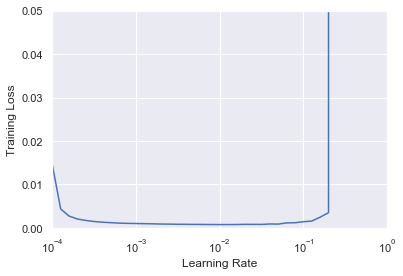

In [124]:
plot_learning_rate_schedule(history_lr, 0.05)

In [ ]:
tf.keras.backend.clear_session()

univariate_lstm = tf.keras.models.Sequential([
    LSTM(80, input_shape=input_shape_univ, return_sequences=True),
    Flatten(),
    Dense(160, activation='relu'),
    Dropout(0.05),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'univariate_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

univariate_lstm.compile(loss=loss,
                        optimizer=optimizer,
                        metrics=metric)

In [ ]:
history = univariate_lstm.fit(train_univ, epochs=120,
                              validation_data=val_univ,
                              callbacks=[early_stopping, 
                                         model_checkpoint])

In [ ]:
plot_model_rmse_and_loss(history)

In [ ]:
univariate_lstm = tf.keras.models.load_model('univariate_lstm.h5')

forecast = univariate_lstm.predict(X_test_univ)
univariate_lstm_forecast = scaler.inverse_transform(forecast)

rmse_univ_lstm = sqrt(mean_squared_error(y_test_univ_inv,
                                         univariate_lstm_forecast))
print('RMSE of hour-ahead load univariate LSTM forecast: {}'
      .format(round(rmse_univ_lstm, 3)))

In [125]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [126]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

In [127]:
dataset = df_final[considered_features]

In [128]:
scaler_mult = MinMaxScaler(feature_range=(0, 1))

scaler_mult.fit(dataset[:train_end_idx])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [129]:
y = df_final['total load actual'].values

scaler = MinMaxScaler(feature_range=(0, 1))

y_reshaped = y.reshape(-1, 1)
scaler.fit(y_reshaped[:train_end_idx])

scaled_price = scaler.transform(y_reshaped)

In [130]:
scaled_dataset = scaler_mult.transform(dataset)

In [131]:
scaled_dataset = np.concatenate((scaled_dataset, scaled_price), axis=1)

In [ ]:
multivariate_past_history = 25

In [ ]:
multivariate_future_target = 0

In [ ]:
X_train_mult, y_train_mult = multivariate_data(scaled_dataset, scaled_dataset[:, -1],
                                               0, train_end_idx, 
                                               multivariate_past_history,
                                               multivariate_future_target,
                                               step=1, single_step=True)

In [ ]:
X_val_mult, y_val_mult = multivariate_data(scaled_dataset, scaled_dataset[:, -1],
                                           train_end_idx, cv_end_idx, 
                                           multivariate_past_history,
                                           multivariate_future_target,
                                           step=1, single_step=True)

In [ ]:
X_test_mult, y_test_mult = multivariate_data(scaled_dataset, scaled_dataset[:, -1],
                                             cv_end_idx, test_end_idx,
                                             multivariate_past_history,
                                             multivariate_future_target,
                                             step=1, single_step=True)

In [ ]:
batch_size = 32
buffer_size = 1000

In [ ]:
train_mult = tf.data.Dataset.from_tensor_slices((X_train_mult, y_train_mult))
train_mult = train_mult.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

In [ ]:
val_mult = tf.data.Dataset.from_tensor_slices((X_val_mult, y_val_mult))
val_mult = val_mult.batch(batch_size).prefetch(1)

In [ ]:
input_shape_mult = X_train_mult.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [ ]:
y_test_mult_reshaped = y_test_mult.reshape(-1, 1)
y_test_mult_inv = scaler.inverse_transform(y_test_mult_reshaped)

In [ ]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(80, input_shape=input_shape_mult, return_sequences=True),
    Flatten(),
    Dense(160, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [ ]:
history_lr = multivariate_lstm.fit(train_mult, epochs=50,
                                   validation_data=val_mult,
                                   callbacks=[lr_schedule])

In [ ]:
plot_learning_rate_schedule(history_lr, 0.05)

In [ ]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(80, input_shape=input_shape_mult, return_sequences=True),
    Flatten(),
    Dense(160, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=5e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [ ]:
history = multivariate_lstm.fit(train_mult, epochs=120,
                                validation_data=val_mult,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

In [ ]:
plot_model_rmse_and_loss(history)

In [ ]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test_mult)
multivariate_lstm_forecast = scaler.inverse_transform(forecast)

rmse_mult_lstm = sqrt(mean_squared_error(y_test_mult_inv,
                                         multivariate_lstm_forecast))
print('RMSE of hour-ahead load multivariate LSTM forecast: {}'
      .format(round(rmse_mult_lstm, 3)))